<a href="https://colab.research.google.com/github/AnaBelenCarbajal/Thesis/blob/main/Baseline_catLearningTask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dataset novel shapes - Baseline**

1) Installing packages

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install osculari

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 8.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvi

In [3]:
#packages
#import osculari
#from osculari.paradigms.forced_choice import paradigm_utils
import torch.nn as nn

import os
import pandas as pd
import torch
import numpy as np
from matplotlib import pyplot as plt

from random import choice, randint
import torchvision.transforms.functional as transform
from torch.utils.data import Dataset
from torchvision.io import read_image, ImageReadMode
from torchvision.transforms import v2
from torchvision.transforms import Pad
from torch.utils.data import DataLoader

from PIL import Image

In [4]:
# unzip folder (previously uploaded in collab)
!unzip '/content/drive/MyDrive/Thesis/Neural_network/Human category learning task/documents/CategoryLearningStimuli.zip' -d my_data

Archive:  /content/drive/MyDrive/Thesis/Neural_network/Human category learning task/documents/CategoryLearningStimuli.zip
   creating: my_data/Stimuli_Set1/
  inflating: my_data/__MACOSX/._Stimuli_Set1  
  inflating: my_data/Stimuli_Set1/63.jpg  
  inflating: my_data/__MACOSX/Stimuli_Set1/._63.jpg  
  inflating: my_data/Stimuli_Set1/189.jpg  
  inflating: my_data/__MACOSX/Stimuli_Set1/._189.jpg  
  inflating: my_data/Stimuli_Set1/77.jpg  
  inflating: my_data/__MACOSX/Stimuli_Set1/._77.jpg  
  inflating: my_data/Stimuli_Set1/162.jpg  
  inflating: my_data/__MACOSX/Stimuli_Set1/._162.jpg  
  inflating: my_data/Stimuli_Set1/176.jpg  
  inflating: my_data/__MACOSX/Stimuli_Set1/._176.jpg  
  inflating: my_data/Stimuli_Set1/88.jpg  
  inflating: my_data/__MACOSX/Stimuli_Set1/._88.jpg  
  inflating: my_data/Stimuli_Set1/348.jpg  
  inflating: my_data/__MACOSX/Stimuli_Set1/._348.jpg  
  inflating: my_data/Stimuli_Set1/360.jpg  
  inflating: my_data/__MACOSX/Stimuli_Set1/._360.jpg  
  inflatin

In [5]:
# root directory to data
root = "my_data/Stimuli_Set1/"
dic_pretraining = '/content/drive/MyDrive/Thesis/Neural_network/Pre-training on Animals shapes/'
dic_baseline = '/content/drive/MyDrive/Thesis/Neural_network/Human category learning task/documents/'

In [6]:
# get category labels
image_ID = os.listdir(root)

#remove ".DS_Store"
image_ID.remove(".DS_Store")
#image_ID.remove(".ipynb_checkpoints")

2) Defining parameters

In [7]:
# conditions
condition1 = {
    'A':[-30, 30],  #low var
    'D':[-80, 80]   #high var
    }

condition2 = {
    'A':[-80, 80], #high var
    'D':[-30, 30]  #low var
    }

In [8]:
# reference shapes angles --> categories
reference_shapeA = 0
reference_shapeB = 310
reference_shapeC = 260
reference_shapeD = 210

3) Get angles and directory

In [9]:
# get angles
angles = []
for image in image_ID:
  get_angle = image.replace('.jpg', '')
  transform_to_int = int(get_angle)
  angles.append(transform_to_int)

In [10]:
angles_720 = np.array(angles) + 360
angles_720 = angles_720.tolist()
angles_720[:5]

[553, 559, 363, 364, 488]

In [67]:
# skip!!!
to_float = []
for i in angles_720:
  float_angle = float(i)
  to_float.append(float_angle)
angles_720 = to_float
angles_720[:5]

[553.0, 559.0, 363.0, 364.0, 488.0]

In [68]:
# get image directories
img_dir = []

for image in image_ID:
  folder_path = root + image
  img_dir.append(folder_path)

4) Create general dataset

In [69]:
data =  {'angle' : angles,
         'angle_720' : angles_720,
         'image' : image_ID,
         'img_dir' : img_dir}
# df
df_data = pd.DataFrame(data)
df_data = df_data.sort_values('angle')

In [70]:
# Create dictionary data
def CreateDictionary (dataframe):
  data_dicts = []

  for i in range(len(dataframe)):
    angle = dataframe.iloc[i, 0]
    angles_720 = dataframe.iloc[i, 1]
    image = dataframe.iloc[i, 2]
    img_dir = dataframe.iloc[i, 3]

    individual_dic =  {'angle' : angle,
                       'angle_720' : angles_720,
                       'image' : image,
                       'img_dir' : img_dir}

    data_dicts.append(individual_dic)
  return data_dicts

In [71]:
data_dict = CreateDictionary(df_data)
data_dict[0]

{'angle': 0,
 'angle_720': 360.0,
 'image': '0.jpg',
 'img_dir': 'my_data/Stimuli_Set1/0.jpg'}

Download positions for nn

In [15]:
# read positions.txt
#read
PATH = '/content/drive/MyDrive/Thesis/Neural_network/Human category learning task/documents/positions.txt'
positions = np.loadtxt(PATH)
positions = positions.tolist()
positions = [[int(float(j)) for j in i] for i in positions]
positions[:5]

[[23, 25, 21, 19],
 [26, 26, 18, 18],
 [31, 7, 13, 37],
 [27, 5, 17, 39],
 [31, 10, 13, 34]]

5) Define functions to create dataset for EACH REFERENCE SHAPE

identical angle = same category

other angle = different category

8) Define class for CNN

In [98]:
import torch
from torchvision import transforms
from PIL import Image

def morph_images(image1_path, image2_path, weight):
    """
    Morphs two images with a given weight.

    Args:
        image1_path (str): Path to the first image.
        image2_path (str): Path to the second image.
        weight (float): The blending weight. 0.0 means only the first image, 1.0 means only the second image.

    Returns:
        PIL.Image: The morphed image.
    """
    # Load the images
    image1 = read_image(image1_path, ImageReadMode.RGB)
    image2 = read_image(image2_path, ImageReadMode.RGB)

    # Ensure the images are the same size
    if image1.size() != image2.size():
        raise ValueError("The two images must be of the same size.")

    # Blend the images
    morphed_tensor = (1 - weight) * image1 + weight * image2

    return morphed_tensor

In [97]:
morph_images('my_data/Stimuli_Set1/0.jpg', 'my_data/Stimuli_Set1/1.jpg', 0.5)

tensor([[[128., 128., 128.,  ..., 128., 128., 128.],
         [128., 128., 128.,  ..., 128., 128., 128.],
         [128., 128., 128.,  ..., 128., 128., 128.],
         ...,
         [128., 128., 128.,  ..., 128., 128., 128.],
         [128., 128., 128.,  ..., 128., 128., 128.],
         [128., 128., 128.,  ..., 128., 128., 128.]],

        [[128., 128., 128.,  ..., 128., 128., 128.],
         [128., 128., 128.,  ..., 128., 128., 128.],
         [128., 128., 128.,  ..., 128., 128., 128.],
         ...,
         [128., 128., 128.,  ..., 128., 128., 128.],
         [128., 128., 128.,  ..., 128., 128., 128.],
         [128., 128., 128.,  ..., 128., 128., 128.]],

        [[128., 128., 128.,  ..., 128., 128., 128.],
         [128., 128., 128.,  ..., 128., 128., 128.],
         [128., 128., 128.,  ..., 128., 128., 128.],
         ...,
         [128., 128., 128.,  ..., 128., 128., 128.],
         [128., 128., 128.,  ..., 128., 128., 128.],
         [128., 128., 128.,  ..., 128., 128., 128.]]]

In [95]:
read_image('my_data/Stimuli_Set1/0.jpg', ImageReadMode.RGB)

tensor([[[128, 128, 128,  ..., 128, 128, 128],
         [128, 128, 128,  ..., 128, 128, 128],
         [128, 128, 128,  ..., 128, 128, 128],
         ...,
         [128, 128, 128,  ..., 128, 128, 128],
         [128, 128, 128,  ..., 128, 128, 128],
         [128, 128, 128,  ..., 128, 128, 128]],

        [[128, 128, 128,  ..., 128, 128, 128],
         [128, 128, 128,  ..., 128, 128, 128],
         [128, 128, 128,  ..., 128, 128, 128],
         ...,
         [128, 128, 128,  ..., 128, 128, 128],
         [128, 128, 128,  ..., 128, 128, 128],
         [128, 128, 128,  ..., 128, 128, 128]],

        [[128, 128, 128,  ..., 128, 128, 128],
         [128, 128, 128,  ..., 128, 128, 128],
         [128, 128, 128,  ..., 128, 128, 128],
         ...,
         [128, 128, 128,  ..., 128, 128, 128],
         [128, 128, 128,  ..., 128, 128, 128],
         [128, 128, 128,  ..., 128, 128, 128]]], dtype=torch.uint8)

In [99]:
class ShapeImageDataset (Dataset):
  # return two images, with 50% chance in same or different category and ground truth

  # __init__
  def __init__(self, length, reference_shape, test_shape, data_dict, positions, transform=None):
    self.length = length
    self.reference_shape = reference_shape
    self.test_shape = test_shape
    self.data = data_dict
    self.transform = transform
    self.positions = positions
    self.left_right = [0,1]

  # __len__
  def __len__(self):
    return self.length

  # function to read images
  def read_image_from_directory(self, img_dir):
    return read_image(img_dir, ImageReadMode.RGB)

  # function to be able to take half degree
  def half_dregree(self, test_shape_angle):
    return round(test_shape_angle * 2) / 2

  # funtion to deal with half degrees
  def to_aveage_images(self, test_shape_angle):
    # get int images surrounding (e.g. 1 and 2 for 1.5)
    upper_img_angle = test_shape_angle + 0.5
    lower_img_angle = test_shape_angle - 0.5
    # upper
    upper_test_shape_image = self.data[int(upper_img_angle)]
    upper_test_shape_dir = upper_test_shape_image['img_dir']
    # lower
    lower_test_shape_image = self.data[int(lower_img_angle)]
    lower_test_shape_dir = lower_test_shape_image['img_dir']

    return upper_test_shape_dir, lower_test_shape_dir

  # __getitem__
  def __getitem__(self, idx):

    # img1 should be reference shape
    ref_shape_image = self.data[self.reference_shape]
    ref_shape_angle = ref_shape_image['angle_720']
    ref_shape_dir = ref_shape_image['img_dir']

    # img2 should be test shape: from all angles
    if self.test_shape > 361:
      test_shape_angle720 = self.test_shape - 360
    else:
      test_shape_angle720 = self.test_shape

    if test_shape_angle720 % 0.5 != 0:
      test_shape_angle = self.half_dregree(test_shape_angle720)
      [image1_path, image2_path] = self.to_aveage_images(test_shape_angle)
      test_image = morph_images(image1_path, image2_path, 0.5)
      # read images
      img1 = self.read_image_from_directory(ref_shape_dir)
      img2 = test_image
    else:
      test_shape_image = self.data[round(test_shape_angle720)]
      test_shape_angle = test_shape_image['angle_720']
      test_shape_dir = test_shape_image['img_dir']
      # read images
      img1 = self.read_image_from_directory(ref_shape_dir)
      img2 = self.read_image_from_directory(test_shape_dir)

    # gt
    if ref_shape_angle == test_shape_angle:
      gt = 1
    elif ref_shape_angle == (test_shape_angle-360): # correct for 360 and 0 same angles
      gt = 1
    elif ref_shape_angle == (test_shape_angle-720): # correct for 360 and 720 same angles
      gt = 1
    else:
      gt = 0

    # apply transformations per image pair
    # resize to 180x180
    resize = v2.Resize([180,180])
    img1 = resize(img1)
    img2 = resize(img2)
    # apply padding
    img1_selected_position = choice(self.positions)
    img2_selected_position = choice(self.positions)
    padding_img1 = Pad(padding = img1_selected_position, fill=128)
    padding_img2 = Pad(padding = img2_selected_position, fill=128)
    img1 = padding_img1(img1)
    img2 = padding_img2(img2)

    # apply more transformations
    if self.transform:
      img1 = self.transform(img1)
      img2 = self.transform(img2)

    # left and right positions change randomly
    # return tensors for image 1 and image 2 and a ground truth
    if choice(self.left_right) == 1:
      img_left = img1
      img_right = img2
    else:
      img_left = img2
      img_right = img1

    return img_left, img_right, gt

9) Create datasets of images

In [168]:
# tranformations to images for NN
preprocess = v2.Compose(
    [   v2.ToDtype(torch.float32, scale=True),
        v2.ColorJitter(brightness=(0.5,1), contrast=(0.3,1), saturation = (0,5), hue=0),
        #v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [169]:
#create dataset dfor RSA
#parameters: length, reference_shape, test_shape, data_dict, positions, transform=None)
len_dataset = 1000
test_shape = 180
dataset_RSA = ShapeImageDataset(len_dataset, reference_shapeA, test_shape, data_dict, positions, preprocess)

In [107]:
dataset_RSA[0]

(tensor([[[0.2724, 0.2724, 0.2724,  ..., 0.2724, 0.2724, 0.2724],
          [0.2724, 0.2724, 0.2724,  ..., 0.2724, 0.2724, 0.2724],
          [0.2724, 0.2724, 0.2724,  ..., 0.2724, 0.2724, 0.2724],
          ...,
          [0.2724, 0.2724, 0.2724,  ..., 0.2724, 0.2724, 0.2724],
          [0.2724, 0.2724, 0.2724,  ..., 0.2724, 0.2724, 0.2724],
          [0.2724, 0.2724, 0.2724,  ..., 0.2724, 0.2724, 0.2724]],
 
         [[0.2724, 0.2724, 0.2724,  ..., 0.2724, 0.2724, 0.2724],
          [0.2724, 0.2724, 0.2724,  ..., 0.2724, 0.2724, 0.2724],
          [0.2724, 0.2724, 0.2724,  ..., 0.2724, 0.2724, 0.2724],
          ...,
          [0.2724, 0.2724, 0.2724,  ..., 0.2724, 0.2724, 0.2724],
          [0.2724, 0.2724, 0.2724,  ..., 0.2724, 0.2724, 0.2724],
          [0.2724, 0.2724, 0.2724,  ..., 0.2724, 0.2724, 0.2724]],
 
         [[0.2724, 0.2724, 0.2724,  ..., 0.2724, 0.2724, 0.2724],
          [0.2724, 0.2724, 0.2724,  ..., 0.2724, 0.2724, 0.2724],
          [0.2724, 0.2724, 0.2724,  ...,

**Plotting Dataset**

In [131]:
def tensor_to_pil(image_tensor):
    return transform.to_pil_image(image_tensor)

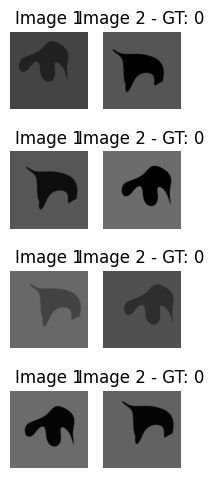

In [170]:
# Example usage to display 5 pairs of images
fig, axs = plt.subplots(4, 2, figsize=(2, 5))

for i in range(4):
    idx = np.random.randint(0, len(dataset_RSA) - 1)
    img1, img2, gt = dataset_RSA[idx]  # Get image pair and ground truth
    img1_pil = tensor_to_pil(img1)
    img2_pil = tensor_to_pil(img2)

    axs[i, 0].imshow(img1_pil)
    axs[i, 0].set_title('Image 1')
    axs[i, 0].axis('off')

    axs[i, 1].imshow(img2_pil)
    axs[i, 1].set_title(f'Image 2 - GT: {gt}')
    axs[i, 1].axis('off')

plt.tight_layout()
#plt.savefig(dic_baseline + 'image_pairs6.pdf')
plt.show()

**Neural network**

Get pre-trained weights

In [29]:
layer = 'block3'

In [28]:
#load pretrained weights
transfer_learning_model = 'weights_224_PositionColorJitter.pt'

PATH = dic_pretraining + transfer_learning_model
pretrained_weights = torch.load(PATH)

In [30]:
#network
architecture = 'resnet50'        # network's architecture
weights = 'resnet50'             # the pretrained weights
img_size = 224                   # network's input size
layer = layer                    # the readout layer
pooling = None
readout_kwargs = {               # parameters for extracting features from the pretrained network
    'architecture': architecture,
    'weights': weights,
    'layers': layer,
    'img_size': img_size,
    'pooling': pooling
}
pretrained_model = osculari.models.paradigm_2afc_merge_concatenate(**readout_kwargs)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 157MB/s]


In [31]:
pretrained_model.load_state_dict(pretrained_weights)

<All keys matched successfully>

Staircase

In [32]:
# test function
"""
            test_fun: Function for evaluating the model. This function must accept three
             positional arguments (i.e., model, db_loader, device). The output of this function
             should be a dictionary containing the key `accuracy`.
"""
test_epoch_fun = osculari.paradigms.forced_choice.test_dataset

In [33]:
# dataset function
"""
            dataset_fun: Function for creating the dataset and dataloader. This function must
             accept one argument (mid_val, i.e., the current value to be tested). This funtion must
             return a tuple of three elements (i.e., dataset, batch_size, threshold).
"""
#parameters: length, reference_shape, test_shape, data_dict, positions, transform=None)
def dataset_fun (len_dataset, reference_shape, test_shape, data_dict, positions, preprocess):
    test_dataset = ShapeImageDataset(len_dataset, test_shape, reference_shape, data_dict, positions, preprocess)
    return test_dataset, 64, 0.749

Staircase function

In [46]:
# run staircases TEST!!!
len_dataset = 2000
db_fun = lambda test_shape: dataset_fun(len_dataset, test_shape, reference_shapeA, data_dict, positions, preprocess)
test_log_right = osculari.paradigms.staircase(pretrained_model, test_epoch_fun, db_fun, low_val=0, high_val=180, max_attempts = 10)
#test_log_left = osculari.paradigms.staircase(pretrained_model, test_epoch_fun, db_fun, low_val=360, high_val=180, max_attempts = 10)

In [81]:
rounded_array = np.round(test_log_right, decimals=2)

formatted_array = np.array([[f"{num:.2f}" for num in row] for row in rounded_array])

# Print the formatted array
for row in formatted_array:
    print(row)

['90.00' '0.93']
['45.00' '0.94']
['22.50' '0.94']
['11.25' '0.95']
['5.62' '0.96']
['2.81' '0.95']
['1.41' '0.95']
['0.70' '0.05']
['1.05' '0.96']
['0.88' '0.05']


In [45]:
test_log_left

array([[270.        ,   0.949     ],
       [315.        ,   0.971     ],
       [337.5       ,   0.965     ],
       [348.75      ,   0.958     ],
       [354.375     ,   0.959     ],
       [357.1875    ,   0.969     ],
       [358.59375   ,   0.952     ],
       [359.296875  ,   0.95      ],
       [359.6484375 ,   0.954     ],
       [359.82421875,   0.943     ]])

In [34]:
# Code to loop over reference shapes
len_dataset = 1000
reference_shapes_list = [reference_shapeA, reference_shapeB, reference_shapeC, reference_shapeD]

#min and max values
def min_max(reference_shape):
  min_1 = reference_shape
  max_1 = reference_shape + 180
  min_2 = reference_shape + 360
  max_2 = max_1
  return [min_1,max_1,min_2,max_2]

min_max_RSA = min_max(reference_shapeA)
min_max_RSB = min_max(reference_shapeB)
min_max_RSC = min_max(reference_shapeC)
min_max_RSD = min_max(reference_shapeD)

In [ ]:
# Staircases (19m T4 GPU)
test_log_RSA_l = []
test_log_RSA_r = []
test_log_RSB_l = []
test_log_RSB_r = []
test_log_RSC_l = []
test_log_RSC_r = []
test_log_RSD_l = []
test_log_RSD_r = []

for reference_shape in reference_shapes_list:
  # set min and max values according to reference shape
  if reference_shape == reference_shapeA:
    [min_1,max_1,min_2,max_2] = min_max_RSA
  elif reference_shape == reference_shapeB:
    [min_1,max_1,min_2,max_2] = min_max_RSB
  elif reference_shape == reference_shapeC:
    [min_1,max_1,min_2,max_2] = min_max_RSC
  else:
    [min_1,max_1,min_2,max_2] = min_max_RSD

  # run staircases
  db_fun = lambda test_shape: dataset_fun(len_dataset, test_shape, reference_shape, data_dict, positions, preprocess)
  test_log_right = osculari.paradigms.staircase(pretrained_model, test_epoch_fun, db_fun, low_val=min_1, high_val=max_1, max_attempts = 10)
  test_log_left = osculari.paradigms.staircase(pretrained_model, test_epoch_fun, db_fun, low_val=min_2, high_val=max_2, max_attempts = 10)

  # append left and right catgegory boundaries
  if reference_shape == reference_shapeA:
    test_log_RSA_r.append(test_log_right)
    test_log_RSA_l.append(test_log_left)
  elif reference_shape == reference_shapeB:
    test_log_RSB_r.append(test_log_right)
    test_log_RSB_l.append(test_log_left)
  elif reference_shape == reference_shapeC:
    test_log_RSC_r.append(test_log_right)
    test_log_RSC_l.append(test_log_left)
  else:
    test_log_RSD_r.append(test_log_right)
    test_log_RSD_l.append(test_log_left)


In [ ]:
PATH = '/content/drive/MyDrive/Thesis/Neural_network/results_staircases/Baseline_224x224/'

def save_as_csv(result, name_string):
  transform_toarray = np.asarray(result)
  formating = transform_toarray[0]
  df = pd.DataFrame(formating)
  path = PATH + name_string + ".csv"
  df.to_csv(path, header=False, index=False)

In [ ]:
save_as_csv(test_log_RSA_r, "test_log_RSA_r")
save_as_csv(test_log_RSA_l, "test_log_RSA_l")
save_as_csv(test_log_RSB_r, "test_log_RSB_r")
save_as_csv(test_log_RSB_l, "test_log_RSB_l")
save_as_csv(test_log_RSC_r, "test_log_RSC_r")
save_as_csv(test_log_RSC_l, "test_log_RSC_l")
save_as_csv(test_log_RSD_r, "test_log_RSD_r")
save_as_csv(test_log_RSD_l, "test_log_RSD_l")

In [ ]:
test_log_RSB_l

[array([[580.        ,   1.        ],
        [625.        ,   1.        ],
        [647.5       ,   1.        ],
        [658.75      ,   1.        ],
        [664.375     ,   1.        ],
        [667.1875    ,   1.        ],
        [668.59375   ,   1.        ],
        [669.296875  ,   1.        ],
        [669.6484375 ,   0.        ],
        [669.47265625,   1.        ]])]

In [ ]:
def formating_to_plot (result):
  transform_toarray = np.asarray(result)
  formated = transform_toarray[0]
  return formated

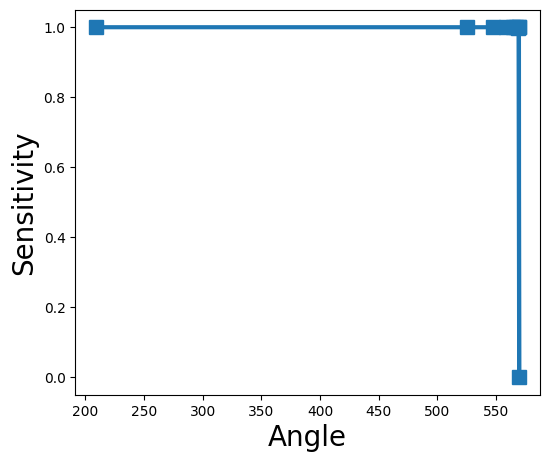

In [ ]:
i = 0

test_log = formating_to_plot(test_log_RSD_l)

for pair in test_log:
  if pair[0] > 361:
    angle_360 = pair[0] - 360
    test_log[i,0] = angle_360
  else:
    pass

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(1, 1, 1,)
sensitivity = test_log[:,1]
sensitivity /= sensitivity.max()
ax.plot(test_log[:,0], sensitivity, '-s', markersize=10, linewidth=3)
ax.set_xlabel('Angle', fontsize=20)
ax.set_ylabel('Sensitivity', fontsize=20)
plt.show()